In [18]:
%matplotlib inline
# autoload the package, for debuge purpose
%load_ext autoreload
%autoreload 2

# import modules and plot setting
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import datetime
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

from mangatools import linmix
from mangatools import maps, datacube, utils
from mangatools.fitmaps import FitMaps

today = datetime.date.today().isoformat()

# set the display properties
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# customize the warning message
import warnings
warnings.filterwarnings("ignore") # default or ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Outflow

alpha: +3.404±0.062, beta: +0.051±0.046, sig^2: 0.061


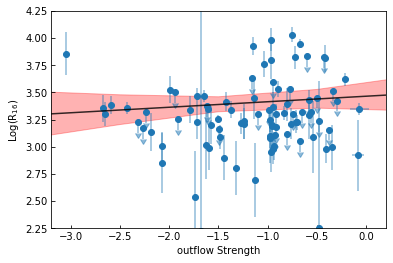

In [19]:
# Outflow strength and the size of ENLR
LO3data = Table.read('data/LO3-2019-03-20.dat', format="ascii")
Rdata = Table.read('data/R_fsb-2019-03-20.dat', format='ascii')
mcmc_fitting = Table.read('data/mcmc.txt', format='ascii')
is_converge = (mcmc_fitting['is_converge'] >= 1)
LO3 = LO3data['LO3_redcorr']
LO3_err = LO3data['LO3_redcorr_err_up']

R = Rdata['logR_fsb2_orig']
R_err = Rdata['logR_fsb2_orig_err']
R_uplims = (Rdata['is_limit'] == 1)
R[R_uplims] = Rdata['logR_fsb2'][R_uplims]

#s = R > 0
# plot the outflow signature
outflow_strength = LO3data['outflow_strength']
outflow_strength_err = LO3data['outflow_strength_err']
ss = (outflow_strength > 0) #& is_converge
fig, ax = plt.subplots(1,1)

#ax.semilogx(outflow_strength, R, 'o')
#ax.errorbar(outflow_strength, R, xerr=outflow_strength_err, yerr=R_err, ls='None', marker=None, alpha=0.5)
#ax.set_xlabel('outflow strength')
#ax.set_ylabel('log(R)')

if 1: # fitting with linmix
    xfit = np.log10(outflow_strength[ss])
    xfit_err = outflow_strength_err[ss]/np.log(10)/xfit
    yfit = R[ss]
    yfit_err = R_err[ss]

    ax.plot(xfit, yfit, 'o', color='C0')
    ax.set_xlabel('outflow Strength')
    ax.set_ylabel(r'Log(R$_{16}$)')
    ax.errorbar(xfit, yfit, xerr=xfit_err, yerr=yfit_err, uplims=R_uplims[ss], ls='None', marker=None, alpha=0.5, color='C0')
    
    lm = linmix.LinMix(xfit, yfit, xfit_err, yfit_err, K=2)
    lm.run_mcmc(silent=True)
    
    #for i in range(0, len(lm.chain), 25):
    #    xs = np.arange(38,46)
    #    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    #    ax.plot(xs, ys, color='r', alpha=0.02)
    curves = []
    xs = np.arange(-3.5, 2.2)
    for i in range(0, len(lm.chain)):
        curves.append(lm.chain[i]['alpha'] + xs * lm.chain[i]['beta'] + lm.chain[i]['sigsqr'])

    # Plot 95% confidence interval
    lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
    #ax.fill_between(xs, lo, hi, color='red', alpha=0.2)
    ax.fill_between(xs, lo, hi, color='red', alpha=0.3)
    alpha, alpha_err = np.mean(lm.chain['alpha']), np.std(lm.chain['alpha'])
    beta, beta_err = np.mean(lm.chain['beta']), np.std(lm.chain['beta'])
    sigsqr = np.mean(lm.chain['sigsqr'])
    print(r"alpha: {:+.3f}±{:.3f}, beta: {:+.3f}±{:.3f}, sig^2: {:.3f}".format(
            alpha, alpha_err, beta, beta_err, sigsqr))
    ax.plot(xs, alpha + xs * beta + sigsqr, 'k-', alpha=0.8)
    ax.set_xlim(-3.2, 0.2)
    ax.set_ylim(2.25, 4.25)
    
if False: # do fitting
    xfit = outflow_strength
    xfit_err = outflow_strength_err
    yfit = R
    yfit_err = R_err
    
    p = lts_linefit(xfit, yfit, xfit_err, yfit_err, clip=3, epsy=True, corr=True, frac=None, 
                    pivot=0, plot=False, text=False)

    # show fitting results
    rms = np.std(p.ab[0] + p.ab[1]*xfit[p.mask] - yfit[p.mask], ddof=2)
    par = np.append(p.ab, p.sig_int)
    sig_par = np.append(p.ab_err, p.sig_int_err)

    xmin, xmax = np.min(xfit), np.max(xfit)
    dx = xmax - xmin
    xlimits = np.array([xmin - dx, xmax + dx])
    y_res = par[0] + par[1]*xlimits
    ax.plot(xlimits, y_res, '-k')
    ax.plot(xlimits, y_res + rms, '--r', alpha=0.3)
    ax.plot(xlimits, y_res - rms, '--r', alpha=0.3)
    #ax.set_title(r"$y = (0.307 \pm 0.021) x - (9.09 \pm 0.86)$", fontsize=fs)
    #ax.text(41., 2.7, "Spearman r=0.78, p=1e-19 \n Pearson r=0.84, p=1e-25", 
    #        fontsize=fs)
fig.savefig('./results/outflow.pdf',  bbox_inches='tight')

# Jets

## 4400\AA luminosity

In [9]:
targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')

Lv_4400 = []

for idx, plateifu in enumerate(targets['plateifu'][:]):
    #plateifu = '7495-1902'
    print(idx, plateifu)
    m = maps.Maps(plateifu)
    dc = datacube.Datacube(plateifu)
    sp = dc.stack2(m.mask, vmap=m.vfield())
    wave_wind = (sp.wave/(1+sp.z) < 4460) & (sp.wave/(1+sp.z) > 4430)
    wave_select = sp.wave[wave_wind]
    flux = 1e-17 / u.angstrom * np.sum(dc.flux[wave_wind])/(wave_select[-1] - wave_select[0]) * 4400**2 *u.angstrom**2 / const.c.to(u.angstrom/u.s)
    Lv = flux / u.cm**2 * 4*np.pi*(m.d**2).to(u.cm**2)
    Lv_4400.append(Lv.value)
    
Lv_4400 = np.array(Lv_4400)
np.savetxt('data/Lv.txt', Lv_4400)

0 7495-1902
1 7815-6104
2 7991-6104
3 7991-3702
4 8132-6101
5 8247-6101
6 8137-3702
7 8141-1901
8 8256-12704
9 8143-6101
10 8249-3704
11 8319-12705
12 8341-12704
13 8329-3701
14 8439-6104
15 8452-1901
16 8483-12703
17 8482-12704
18 8549-12701
19 8465-12704
20 8552-9102
21 8552-12701
22 8318-3704
23 8318-6102
24 8464-6101
25 8320-3704
26 8550-3704
27 8606-12701
28 8611-3704
29 7992-9102
30 8603-6101
31 8612-12702
32 8612-12704
33 8588-12704
34 8602-12701
35 8077-6103
36 8147-6102
37 8146-12705
38 8084-6103
39 8718-12702
40 8718-12701
41 8725-9102
42 10001-6102
43 8715-3702
44 8255-6101
45 8241-6102
46 8241-9102
47 8720-1901
48 8547-12701
49 8978-9101
50 8978-12705
51 8978-6102
52 8979-6102
53 8948-12704
54 8946-3701
55 8947-3701
56 8945-3703
57 8597-3703
58 9026-9101
59 9049-1901
60 9002-12702
61 9031-1902
62 9027-12704
63 8982-3703
64 7972-6103
65 9025-12704
66 7958-9101
67 9195-3703
68 8080-12703
69 9182-6102
70 9193-12701
71 8940-12702
72 9183-3703
73 8993-12705
74 8992-3702
75 9485-

## Radio luminosity

In [10]:
# calculate the radio luminosity
targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')
c_targets = SkyCoord(ra=targets['ra']*u.degree, dec=targets['dec']*u.degree)

first = Table.read('data/first_14dec17.fits.gz')
first[:3]

c_first = SkyCoord(ra=first['RA'], dec=first['DEC'])

idx, d2d, d3d = c_targets.match_to_catalog_sky(c_first)
matched = d2d < 5*u.arcsec

first_flux = np.zeros(len(targets))
first_flux[matched] = first[idx]['FINT'][matched]

In [20]:
# calculate the radio loudness
LO3data = Table.read('data/LO3-2019-03-20.dat', format="ascii")
Lv_4400 = np.array(Lv_4400)

Lv_5GHz_list = []
loudness = []
for idx, gal in enumerate(LO3data[:]):
    plateifu = gal['plateifu']
    m = maps.Maps(plateifu)
    LO3 = gal['LO3_redcorr']
    f_22cm = first_flux[idx] * 1e-26  # mJy to erg/s/cm^2/Hz, 22cm ~ 1.363GHz
    f_5GHz = 10**(np.log10(f_22cm) - 0.5*(np.log10(5e9)-np.log10(1.363e9)))
    Lv_22cm = f_22cm /(u.cm**2) * 4*np.pi*(m.d**2).to(u.cm**2) # 22cm luminosity
    Lv_5GHz = f_5GHz /(u.cm**2) * 4*np.pi*(m.d**2).to(u.cm**2)
    #print(Lv_22cm, Lv_5GHz)
    #logL_22cm = np.log10(L_22cm.value+1e-8)
    Lv_5GHz_list.append(Lv_5GHz)
    loudness.append(Lv_5GHz / Lv_4400[idx])
    print(LO3, Lv_5GHz, Lv_5GHz / Lv_4400[idx])
#first_L = np.array(first_L)
loudness = np.array(loudness)
np.savetxt('data/loudness.txt', loudness)

39.56879582639838 0.0 0.0
42.532838841574296 1.4172021745018836e+29 1.8009376182584569
40.744094490280546 0.0 0.0
40.448036528408394 0.0 0.0
41.61300503239234 0.0 0.0
39.92630693535044 8.010381837772192e+27 0.330003072310479
41.89273550562034 0.0 0.0
40.951102082145276 0.0 0.0
41.84857675400442 2.8991372232141217e+29 1.2332628659856282
42.00989984067382 1.697127769822332e+30 8.29813498978744
40.870631047832035 2.7741970084842744e+28 2.2915633397824813
40.5507687530997 0.0 0.0
40.859602947341955 3.568401858958865e+28 0.49020462088754996
40.33229578801435 3.84820713792338e+30 50.84323075632033
40.823833155520376 1.2169303910894458e+29 1.9433477425266172
40.101236361828434 0.0 0.0
40.269512135981266 0.0 0.0
40.626429617333564 3.2943286073674426e+30 25.100245362342687
41.03948210122205 7.137524618660554e+28 1.1436821651140725
41.039968314254324 7.151757872945247e+28 2.06415885812057
40.49709527039684 0.0 0.0
40.46671699362966 0.0 0.0
40.26614960064118 2.1848944016494718e+28 1.4399622876769

## Morphology with jet

In [21]:
# Plot the Ha, to check the classification of type-I galaxies

import matplotlib.backends.backend_pdf as mpdf

fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/' #set to your local folder
save = False
plot = False
show_detail = True
agn_type = []

if save:
    plt.ioff() #turnoff the inline plot, just save them to file
    pdf = mpdf.PdfPages('results/Hbmap-{}.pdf'.format(today))
    i=0

targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')
tot_num = len(targets[:])
for i in range(tot_num):
    plateifu = targets['plateifu'][i]
    m = maps.Maps(plateifu)
    fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
    Hb_narrow = fm.line('Hbeta')
    Hb_broad = fm.line('_Hbeta')
    a, b = Hb_narrow[0].shape
    ratio = Hb_broad[0, a//2, b//2] / Hb_narrow[0, a//2, b//2]
    snr = Hb_broad[0, a//2, b//2]/Hb_broad[1, a//2, b//2]
    pixels = np.sum((Hb_broad[0] / Hb_broad[1]) > 5)
    if show_detail:
        #print("{}: {}, ratio:{}, snr:{}, pixels:{}")
        if ((ratio > 0) & (snr > 5)) & (pixels > 5):
            print(i, plateifu)
            agn_type.append(1)
            plot = True
        else:
            agn_type.append(2)
            plot = False
    
    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(8, 6))
        plt.suptitle("{}: ratio={:.2f}, snr={:.2f}, pixels={}".format(
                      plateifu, ratio, snr, pixels))
        m.image(ax=ax[0,0], showImage=False, mini=True)
        m.bpt2d(ax=ax[0,1], showImage=False, show_psf=True, mini=True)
        m.line('Ha-6564', plot=True, ax=ax[0,2], showImage=False, redcorr=False, mini=True)
        # fitting map
        im10 = ax[1,0].imshow(Hb_narrow[0], origin='lower')
        ax[1,0].set_title('Hb_narrow', fontsize=10)
        fig.colorbar(im10, ax=ax[1,0], fraction=0.046, pad=0.04)
        im11 = ax[1,1].imshow(Hb_broad[0], origin='lower')
        ax[1,1].set_title('Hb_broad', fontsize=10)
        fig.colorbar(im11, ax=ax[1,1], fraction=0.046, pad=0.04)
        im12 = ax[1,2].imshow(Hb_narrow[0] + Hb_broad[0], origin='lower')
        ax[1,2].set_title('Hb_narrow + Hb_broad', fontsize=10)
        fig.colorbar(im12, ax=ax[1,2], fraction=0.046, pad=0.04)

        plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.2)
        if save:
            pdf.savefig(fig)
        plt.close()
        #utils.processBar(tot_num-1, i)
if save:
    pdf.close()
    %matplotlib inline
    print("Done! Plot into results/Hbmap-{}.pdf".format(today))

#agn_type = np.array(agn_type)

1 7815-6104
12 8341-12704
39 8718-12702
41 8725-9102
43 8715-3702
45 8241-6102
63 8982-3703
72 9183-3703
74 8992-3702
76 9487-3702
80 8311-6104
92 9048-1902


In [24]:
LO3data = Table.read('data/LO3-2019-03-20.dat', format="ascii")
Rdata = Table.read('data/R_fsb-2019-03-20.dat', format='ascii')

LO3 = LO3data['LO3_redcorr']
LO3_err = LO3data['LO3_redcorr_err_up']

R = Rdata['logR_fsb2_orig']
R_err = Rdata['logR_fsb2_orig_err']
is_limit = Rdata['is_limit'].data == 1
R[is_limit] = Rdata['logR_fsb2'].data[is_limit]

mcmc_fitting = Table.read('data/mcmc.txt', format='ascii')
is_converge = (mcmc_fitting['is_converge'] >= 1)

#LO3 = LO3[is_converge]
#LO3_err = LO3_err[is_converge]
#R = R[is_converge]
#R_err = R_err[is_converge]

# plot the ENLR shape
NLR_round = []
NLR_twoside = []
NLR_oneside = []
NLR_unresolved = []
all_list = []
all_morphology = []
for i in range(len(LO3data['plateifu'])):
    #if not is_converge[i]:
    #    continue
    shape = None
    plateifu = LO3data['plateifu'][i]
    m = maps.Maps(plateifu)
    O3_i = LO3[i]
    O3_err_i = LO3_err[i]
    R_i = R[i]
    try:
        r1, r2 = m.eshape()
    except:
        print("Error when doing {}".format(plateifu))
        continue
    #print(r1, r2)
    if r2 >= 0.3:
        if r1 > r2:
            NLR_oneside.append([O3_i, R_i])
            shape = 'conical'
        else:
            NLR_twoside.append([O3_i, R_i])
            shape = 'bi-conical'
    elif r1 >= 0.3:
        NLR_oneside.append([O3_i, R_i])
        shape = 'conical'
    else:
        NLR_round.append([O3_i, R_i])
        shape = 'round'
    all_list.append([r1, r2])
    all_morphology.append(shape)

### Plot the results

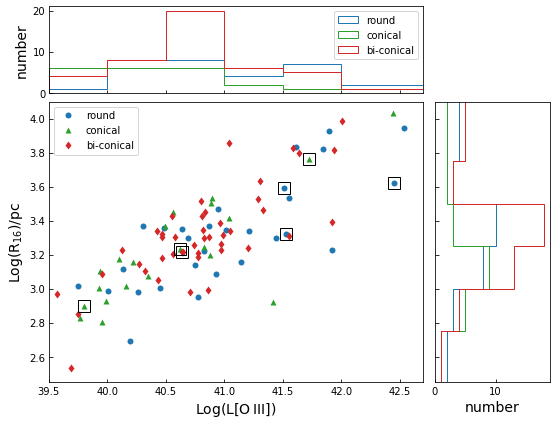

In [25]:
# plot
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()  

set_matplotlib_formats('png')
fig = plt.figure(figsize=(8,6))
fs=14
xbins = [39.5, 40, 40.5, 41, 41.5, 42, 43]
ybins = [2., 2.75, 3. ,3.25, 3.5, 3.75, 4.5]
cols = ['C0', 'C2', 'C3']
agn_type = np.array(agn_type)

if True:
    # plot different shape
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    # start with a rectangular Figure
    ax = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    NLR_round = np.array(NLR_round)
    NLR_twoside = np.array(NLR_twoside)
    NLR_oneside = np.array(NLR_oneside)
    NLR_unresolved = np.array(NLR_unresolved)
    S_round = ax.plot(NLR_round[:,0], NLR_round[:,1], linestyle='None', marker='o', label='round', markeredgecolor='None', markerfacecolor=cols[0])
    S_oneside = ax.plot(NLR_oneside[:,0], NLR_oneside[:,1], linestyle='None', marker='^', label='conical',  markeredgecolor='None', markerfacecolor=cols[1])
    S_twoside = ax.plot(NLR_twoside[:,0], NLR_twoside[:,1], linestyle='None', marker='d', label='bi-conical',  markeredgecolor='None', markerfacecolor=cols[2])
    #ax.plot(NLR_unresolved[:,0], NLR_unresolved[:,1], 'o', label='unresolved', alpha=0.1)
    #plt.legend()
    # plot hist
    binwidth = 0.25

    ax.set_xlim((39.5, 42.7))
    ax.set_ylim((2.45, 4.1))
    
    #axHistx.step((bins1[1:] + bins1[:-1])/2, n1/ntotal)
    #axHistx.step((bins2[1:] + bins2[:-1])/2 + 0.01, n2/ntotal)
    #axHistx.step((bins3[1:] + bins3[:-1])/2 + 0.02, n3/ntotal)
    axHistx.hist(NLR_round[:,0], bins=xbins, histtype='step', color=cols[0], alpha=1, label='round')
    axHistx.hist(NLR_oneside[:,0], bins=xbins, histtype='step', color=cols[1], label='conical', alpha=1)
    axHistx.hist(NLR_twoside[:,0], bins=xbins, histtype='step', color=cols[2], alpha=1, label='bi-conical')
    axHisty.hist(NLR_round[:,1], bins=ybins, orientation='horizontal', histtype='step', color=cols[0], alpha=1)
    axHisty.hist(NLR_oneside[:,1], bins=ybins, orientation='horizontal', histtype='step', color=cols[1])
    axHisty.hist(NLR_twoside[:,1], bins=ybins, orientation='horizontal', histtype='step', color=cols[2], alpha=1)

    axHistx.set_xlim(ax.get_xlim())
    axHisty.set_ylim(ax.get_ylim())

if 1:
    #have_jet = first_L > 38
    have_jet = loudness > 10
    for i, ss in enumerate(have_jet):
        if ss:#and is_converge[i]:
            ax.plot(LO3[i], R[i], color='k', marker='s', label=None, linestyle='None', 
                    markersize=12, markerfacecolor='None', alpha=1)

if 0:
    type1_agn = agn_type == 1
    for i, tp in enumerate(type1_agn):
        if tp:
             ax.plot(LO3[i], R[i], color='m', marker='o', label=None, linestyle='None', 
                    markersize=10, markerfacecolor='None', alpha=1)
            
            
ax.set_xlabel(r"${\rm Log(L[O\,III])}$", fontsize=fs)
ax.set_ylabel(r"Log(R$_{16}$)/pc", fontsize=fs)
ax.legend()
axHistx.set_ylabel('number', fontsize=fs)
axHisty.set_xlabel('number', fontsize=fs)
axHistx.legend()
plt.show()
#plt.legend([S_round, S_twoside, S_oneside, (S_round, Outflow)], ["Attr A", "Attr A+B"])   
fig.savefig('./results/ENLR_morphology.pdf',  bbox_inches='tight')
set_matplotlib_formats('png')

In [ ]:
targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')

with open('data/morphology-{}.dat'.format(today), 'w') as f:
    f.write("# AGNs_file: data/AGNs-2019-03-20.dat\n")
    f.write("# morphology related data\n")
    f.write("{} {} {} {}\n".format("plateifu", "shape", "agn_type", "radio_loudness"))
    
    tot_num = len(targets[:])
    for i in range(tot_num):
        plateifu = targets['plateifu'][i]
        f.write("{} {} {} {}\n".format(plateifu, all_morphology[i], agn_type[i], loudness[i]))

    print('Done! Write into {}'.format(f.name))